In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.chdir('../..')

## 1. SST

In [3]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_SST_BERT.pickle', 'rb'))

In [4]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

## Generate table heatmap


In [5]:
np.argsort(-np.abs([3.1, -100, 10]))

array([1, 2, 0])

In [6]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue

    del df['spearman']
        
    df['top_k_idx_orig'] = df.apply(
        lambda x: 
        set(
            np.argsort(
                -np.abs(x[f'shap_orig_values'])  # abs to ignore direction of importance value
            )[:k]
        ), 
        axis=1
    )
    df['top_k_idx_perturb'] = df.apply(
        lambda x: 
        set(
            np.argsort(
                -np.abs(x[f'shap_{perturbation}_values'])
            )[:k]
        ), 
        axis=1
    )

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean': df['k_intersection'].mean(),
        'top_k_std': df['k_intersection'].std(),
        'spearman_mean': df['spearman'].mean(),
        'spearman_std': df['spearman'].std(),
        'count': df['k_intersection'].count()
    }

In [7]:
PERTURBATION_FULL_FORM_DICT = {
    'strip_punct': 'Strip end punctuation',
    'remove_commas': 'Remove commas',
    'remove_all_punct': 'Remove all punctuation',
    'change_first_name': 'Change first name',
    'change_last_name': 'Change last name',
    'change_location': 'Change location',
    'add_typo': 'Add typo',
    'switch_gender': 'Switch gender',
    'swap_adj': 'Swap adjective'
}

In [8]:
results_df = pd.DataFrame(results_dict).T
results_df.rename(index=PERTURBATION_FULL_FORM_DICT, columns={'top_k_mean': 'Mean top-5 intersection (± sd)', 'spearman_mean': "Mean Spearman (± sd)"}, inplace=True)
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,count
Strip end punctuation,0.825344,0.270087,0.830875,0.225575,363.0
Remove commas,0.548352,0.354564,0.582265,0.335917,182.0
Remove all punctuation,0.681667,0.320560,0.613514,0.361627,240.0
Change first name,0.809756,0.316073,0.902063,0.164488,41.0
Change last name,0.860870,0.285624,0.900805,0.151217,23.0
Change location,0.880000,0.109545,0.866566,0.138374,5.0
Add typo,0.885714,0.174028,0.832741,0.241640,21.0
Switch gender,0.917073,0.223498,0.960039,0.056319,41.0
Swap adjective,0.785714,0.354872,0.874816,0.154373,14.0


In [9]:
# Create string labels with mean and std
for i in range(10):
    results_df[f'label_top_k'] = np.round(results_df[f'Mean top-5 intersection (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'top_k_std'], 2).astype(str) + ')'
    results_df[f'label_spearman'] = np.round(results_df[f'Mean Spearman (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'spearman_std'], 2).astype(str) + ')'

In [10]:
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,count,label_top_k,label_spearman
Strip end punctuation,0.825344,0.270087,0.830875,0.225575,363.0,0.83 (±0.27),0.83 (±0.23)
Remove commas,0.548352,0.354564,0.582265,0.335917,182.0,0.55 (±0.35),0.58 (±0.34)
Remove all punctuation,0.681667,0.320560,0.613514,0.361627,240.0,0.68 (±0.32),0.61 (±0.36)
Change first name,0.809756,0.316073,0.902063,0.164488,41.0,0.81 (±0.32),0.9 (±0.16)
Change last name,0.860870,0.285624,0.900805,0.151217,23.0,0.86 (±0.29),0.9 (±0.15)
Change location,0.880000,0.109545,0.866566,0.138374,5.0,0.88 (±0.11),0.87 (±0.14)
Add typo,0.885714,0.174028,0.832741,0.241640,21.0,0.89 (±0.17),0.83 (±0.24)
Switch gender,0.917073,0.223498,0.960039,0.056319,41.0,0.92 (±0.22),0.96 (±0.06)
Swap adjective,0.785714,0.354872,0.874816,0.154373,14.0,0.79 (±0.35),0.87 (±0.15)


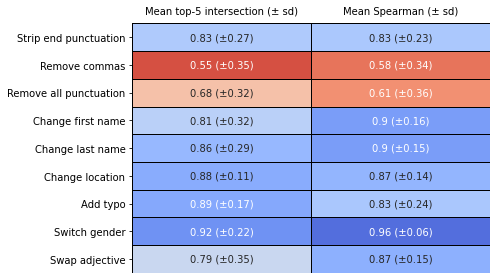

In [11]:
plt.figure(figsize=(7, 4))
sns.heatmap(
    results_df.drop(['top_k_std', 'spearman_std', 'label_top_k', 'label_spearman', 'count'], axis=1), 
    cbar=False, 
    vmin=0.5,
    vmax=1,
    annot=results_df[['label_top_k', 'label_spearman']].values,
    fmt='',
    cmap='coolwarm_r', 
    linewidths=1, 
    linecolor='black'
)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.tight_layout()
plt.rcParams['axes.facecolor'] = 'white'
plt.savefig('reports/figures/bert_shap/bert_shap_mean_score_heat_table_SST.pdf')
plt.show()

### Explore individual cases

In [12]:
# # Sample examples
# perturbation_df_dict['remove_commas'][
#     (perturbation_df_dict['remove_commas']['k_intersection'] < 0.5) &
#     (perturbation_df_dict['remove_commas']['correct_prediction'] == 1)
# ].sample(n=2)

In [13]:
def plot_examples(perturbation, num_examples, return_df=False, idx_list=None, savefig=False, filename=None):
    
    perturbation_df = perturbation_df_dict[perturbation].copy()
    
    if idx_list:
        num_examples = len(idx_list)
    
    for i in range(num_examples):
        
        if idx_list:
            idx = idx_list[i]
            example = perturbation_df.loc[idx]
        else:
            idx = np.random.choice(len(perturbation_df))
            example = perturbation_df.iloc[idx]
        
        example_df = pd.DataFrame({
            'shap_orig_tokens': example['shap_orig_tokens'],
            'shap_orig_values': example['shap_orig_values'],
            f'shap_{perturbation}_tokens': example[f'shap_{perturbation}_tokens'],
            f'shap_{perturbation}_values': example[f'shap_{perturbation}_values']
        })
        
        # MinMax scale to get scores within 0,1
        example_df['shap_orig_values'] = MinMaxScaler().fit_transform(np.abs(example_df['shap_orig_values'].values.reshape(-1, 1))).flatten()
        example_df[f'shap_{perturbation}_values'] = MinMaxScaler().fit_transform(np.abs(example_df[f'shap_{perturbation}_values'].values.reshape(-1, 1))).flatten()
        
        # Sort by SHAP scores before perturbation
        example_df.sort_values('shap_orig_values', ascending=False, inplace=True)
        example_df.reset_index(drop=True, inplace=True)
        
        print(f"Original sentence: {example['sentence']}")
        print(f"Model prediction: {example['orig_prediction']}")
        print(f"Top-5 intersection: {example['k_intersection']}")
        print(f"Spearman: {np.round(example['spearman'], 2)}")
        
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x=example_df.index, y='shap_orig_values', data=example_df, ci=None, color='blue', alpha=0.3, label='Original')
        ax = sns.barplot(x=example_df.index, y=f'shap_{perturbation}_values', data=example_df, ci=None, color='red', alpha=0.3, label=PERTURBATION_FULL_FORM_DICT[perturbation])
        ax.set_xticklabels(example_df['shap_orig_tokens'])
        ax.set_xlabel('Token')
        ax.set_ylabel('Normalised SHAP score')
        plt.tight_layout()
        plt.gcf().subplots_adjust(bottom=0.5)
        plt.xticks(rotation=90)
        plt.legend()
        
        if savefig:
            plt.savefig(f'reports/figures/bert_shap/{filename}', bbox_inches='tight')
        
        plt.show()
        
        if return_df:
            return example_df

In [14]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

Original sentence: Delivers the same old same old , tarted up with Latin flava and turned out by Hollywood playas .
Model prediction: 1
Top-5 intersection: 0.4
Spearman: -0.24


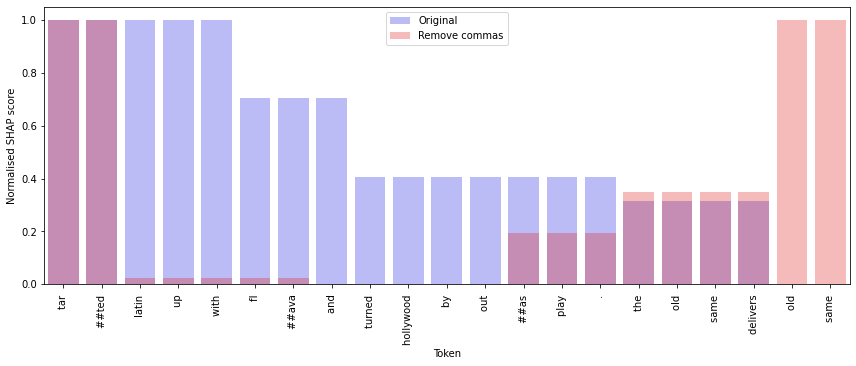

In [15]:
_ = plot_examples(perturbation='remove_commas', num_examples=-99, return_df=True, idx_list=[737], savefig=True, filename='remove_commas_sst_word_plot.png')

Original sentence: The weight of the piece , the unerring professionalism of the chilly production , and the fascination embedded in the lurid topic prove recommendation enough .
Model prediction: 3
Top-5 intersection: 0.2
Spearman: 0.47


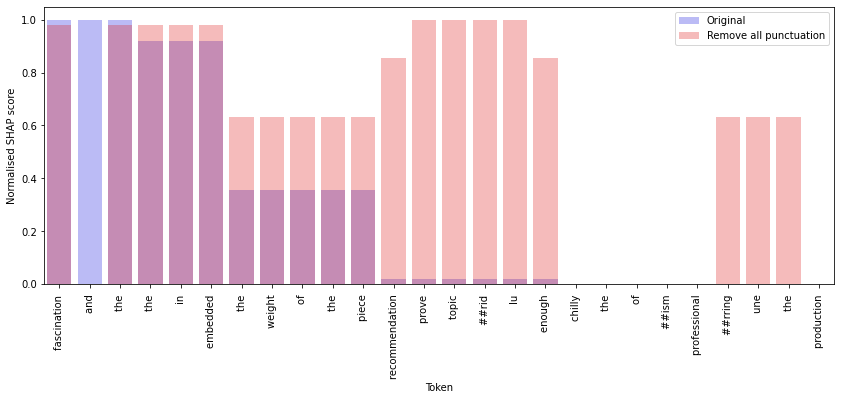

In [16]:
_ = plot_examples(perturbation='remove_all_punct', num_examples=-99, return_df=True, idx_list=[263], savefig=True, filename='remove_all_punct_sst_word_plot.png')

Multiple sampled plots:

In [17]:
# for pert in ['remove_all_punct']:
#     print(
# f"""
# ================================================
# {pert}
# ================================================
# """
# )
#     _ = plot_examples(perturbation=pert, num_examples=5, idx_list=[858, 780, 763, 174, 340])
#     print('\n')

## Check examples

In [18]:
%%capture

pert = 'remove_all_punct'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [19]:
example_df.head()

,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values
0,spirit,1.000000,spirit,1.000000
1,of,1.000000,of,1.000000
2,a,0.593728,a,0.478770
3,man,0.593728,man,0.478770
4,and,0.288180,and,0.285775


In [20]:
# Check tokens the same
assert (
    example_df['shap_orig_tokens'].values == 
    example_df[f'shap_{pert}_tokens'].values
).mean() == 1

In [21]:
%%capture

pert = 'switch_gender'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [22]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_switch_gender_tokens,shap_switch_gender_values
35,he,0.0,she,2.775558e-17


In [23]:
%%capture

pert = 'add_typo'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [24]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_add_typo_tokens,shap_add_typo_values
29,wo,0.0,w,0.0
30,n,0.0,on,0.0


In [25]:
%%capture

pert = 'swap_adj'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [26]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_swap_adj_tokens,shap_swap_adj_values
2,juvenile,1.000000,near,0.152957
11,near,0.188098,juvenile,1.000000


## 2. AG News

In [27]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_AGNews_BERT.pickle', 'rb'))

In [28]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

## Generate table heatmap

In [29]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue

    df['top_k_idx_orig'] = df.apply(
        lambda x: 
        set(
            np.argsort(
                -np.abs(x[f'shap_orig_values'])
            )[:k]
            ),
            axis=1
        )
    df['top_k_idx_perturb'] = df.apply(
        lambda x: 
        set(
            np.argsort(
                -np.abs(x[f'shap_{perturbation}_values'])
            )[:k]
        ),
        axis=1
    )

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean': df['k_intersection'].mean(),
        'top_k_std': df['k_intersection'].std(),
        'spearman_mean': df['spearman'].mean(),
        'spearman_std': df['spearman'].std(),
        'count': df['spearman'].count()
    }

In [30]:
results_df = pd.DataFrame(results_dict).T
results_df.rename(index=PERTURBATION_FULL_FORM_DICT, columns={'top_k_mean': 'Mean top-5 intersection (± sd)', 'spearman_mean': "Mean Spearman (± sd)"}, inplace=True)
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,count
Strip end punctuation,0.763889,0.317242,0.872360,0.222262,360.0
Remove commas,0.446875,0.387640,0.572320,0.374721,256.0
Remove all punctuation,0.429787,0.358484,0.518757,0.354435,235.0
Change first name,0.854321,0.270208,0.919937,0.149176,81.0
Change last name,0.868000,0.263756,0.940424,0.126621,50.0
Change location,0.912281,0.207080,0.914852,0.154090,57.0
Add typo,0.836364,0.300072,0.874396,0.170384,22.0
Switch gender,0.915217,0.180922,0.935079,0.130559,92.0
Swap adjective,0.733333,0.384550,0.910803,0.120745,12.0


In [31]:
# Create string labels with mean and std
for i in range(10):
    results_df[f'label_top_k'] = np.round(results_df[f'Mean top-5 intersection (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'top_k_std'], 2).astype(str) + ')'
    results_df[f'label_spearman'] = np.round(results_df[f'Mean Spearman (± sd)'], 2).astype(str) + ' (±' + np.round(results_df[f'spearman_std'], 2).astype(str) + ')'

In [32]:
results_df

,Mean top-5 intersection (± sd),top_k_std,Mean Spearman (± sd),spearman_std,count,label_top_k,label_spearman
Strip end punctuation,0.763889,0.317242,0.872360,0.222262,360.0,0.76 (±0.32),0.87 (±0.22)
Remove commas,0.446875,0.387640,0.572320,0.374721,256.0,0.45 (±0.39),0.57 (±0.37)
Remove all punctuation,0.429787,0.358484,0.518757,0.354435,235.0,0.43 (±0.36),0.52 (±0.35)
Change first name,0.854321,0.270208,0.919937,0.149176,81.0,0.85 (±0.27),0.92 (±0.15)
Change last name,0.868000,0.263756,0.940424,0.126621,50.0,0.87 (±0.26),0.94 (±0.13)
Change location,0.912281,0.207080,0.914852,0.154090,57.0,0.91 (±0.21),0.91 (±0.15)
Add typo,0.836364,0.300072,0.874396,0.170384,22.0,0.84 (±0.3),0.87 (±0.17)
Switch gender,0.915217,0.180922,0.935079,0.130559,92.0,0.92 (±0.18),0.94 (±0.13)
Swap adjective,0.733333,0.384550,0.910803,0.120745,12.0,0.73 (±0.38),0.91 (±0.12)


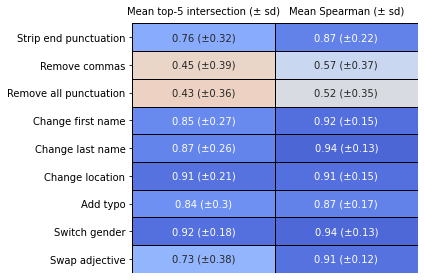

In [33]:
sns.heatmap(
    results_df.drop(['top_k_std', 'spearman_std', 'label_top_k', 'label_spearman', 'count'], axis=1), 
    cbar=False, 
    vmin=0,
    vmax=1,
    annot=results_df[['label_top_k', 'label_spearman']].values,
    fmt='',
    cmap='coolwarm_r', 
    linewidths=1, 
    linecolor='black'
)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.tight_layout()
plt.show()

### Explore individual cases

In [34]:
# Sample examples
perturbation_df_dict['remove_all_punct'][
    (perturbation_df_dict['remove_all_punct']['k_intersection'] < 0.5) &
    (perturbation_df_dict['remove_all_punct']['correct_prediction'] == 1)
].sample(n=2)

,index,sentence,label,title,tokens_orig,remove_all_punct_concat,remove_all_punct_tokens,remove_all_punct_success,remove_all_punct_pert_ind,orig_prediction,...,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values,most_important_indices,important_token_changed,token_length_mismatch,top_k_idx_orig,top_k_idx_perturb,k_intersection,spearman
5001,113001,"Thomson announced its decision, on Thursday, t...",3,Thomson to introduce HD DVD players in 2005,"[thomson, announced, its, decision, ,, on, thu...",thomson announced its decision on thursday t...,"[thomson, announced, its, decision, , on, thur...",1,"[4, 7, 13, 18, 27]",3,...,"[-0.014101149018720857, -0.014101149018720857,...","[thomson , announced , its , decision , on , t...","[-0.013263303911886536, -0.013263303911886536,...","[12, 11, 10, 8, 9]",0,0,"{6, 7, 8, 9, 10}","{8, 9, 15, 16, 17}",0.4,0.593862
4578,112578,A military plane crashes in a mountainous area...,0,Venezuelan plane crash kills 16,"[a, military, plane, crashes, in, a, mountaino...",a military plane crashes in a mountainous area...,"[a, military, plane, crashes, in, a, mountaino...",1,"[10, 14]",0,...,"[0.04554786778647791, 0.04554786778647791, 0.0...","[a , military , plane , crashes , in , a , mou...","[0.03269635699689388, 0.03269635699689388, 0.0...","[11, 12, 2, 3, 0]",0,0,"{0, 2, 3, 10, 11}","{8, 9, 10, 11, 12}",0.4,0.216611


In [35]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

Original sentence: AP - Ukrainian prosecutors reopened their investigation into allegations Viktor Yushchenko was poisoned after doctors treating the opposition leader confirmed he had been slipped the toxic chemical dioxin, as Yushchenko returned home Sunday to campaign for this month's presidential runoff vote.
Model prediction: 0
Top-5 intersection: 0.0
Spearman: 0.42


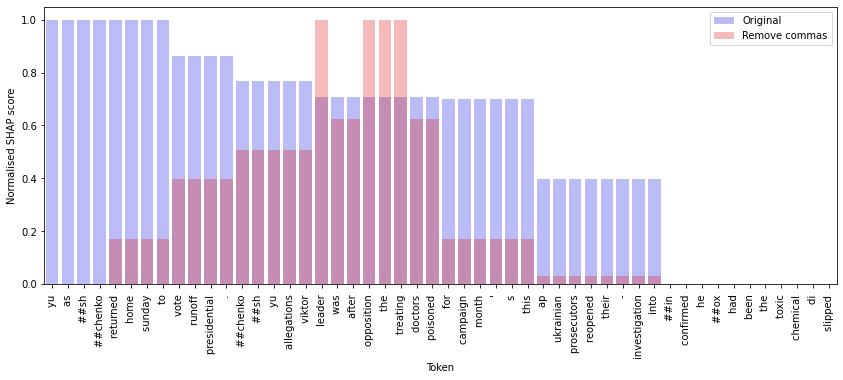

In [36]:
_ = plot_examples(perturbation='remove_commas', num_examples=-99, return_df=True, idx_list=[5816], savefig=True, filename='remove_commas_agnews_word_plot.png')

Original sentence: A quick analysis of players picked in the major league portion of the 2004 Rule 5 draft held Monday. Each selection costs $50,000.
Model prediction: 1
Top-5 intersection: 0.0
Spearman: 0.34


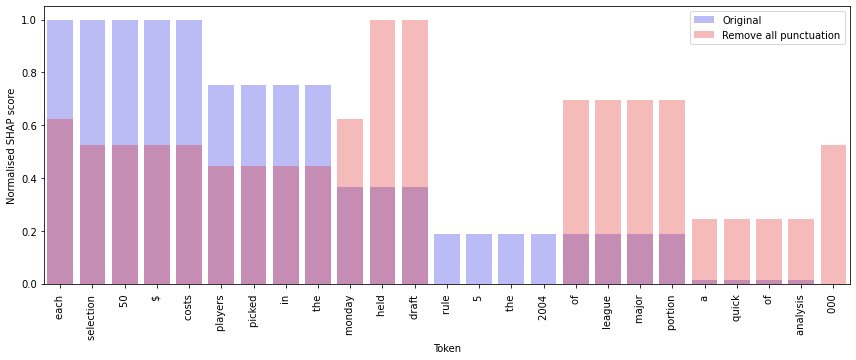

In [37]:
_ = plot_examples(perturbation='remove_all_punct', num_examples=-99, return_df=True, idx_list=[6977], savefig=True, filename='remove_all_punct_agnews_word_plot.png')

Plot multiple samples:

In [38]:
# for pert in perturbation_df_dict.keys():
#     print(
# f"""
# ================================================
# {pert}
# ================================================
# """
# )
#     plot_examples(perturbation=pert, num_examples=5)
#     print('\n')

## Check examples

In [39]:
%%capture

pert = 'remove_all_punct'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [40]:
example_df.head()

,shap_orig_tokens,shap_orig_values,shap_remove_all_punct_tokens,shap_remove_all_punct_values
0,has,1.000000,has,0.566956
1,baseball,1.000000,baseball,0.566956
2,a,1.000000,a,0.566956
3,ever,1.000000,ever,0.566956
4,##ed,0.399606,##ed,0.315174


In [41]:
# Check tokens the same
assert (
    example_df['shap_orig_tokens'].values == 
    example_df[f'shap_{pert}_tokens'].values
).mean() == 1

In [42]:
%%capture

pert = 'switch_gender'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [43]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_switch_gender_tokens,shap_switch_gender_values
26,his,0.794415,her,0.864133
28,his,0.103064,her,0.118130


In [44]:
%%capture

pert = 'add_typo'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [45]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_add_typo_tokens,shap_add_typo_values
10,##isi,0.812842,##cis,8.325483e-01
17,##ve,0.812842,##ive,8.325483e-01
19,inc,0.812842,sin,8.325483e-01
39,##rs,0.000000,##r,6.938894e-18


In [46]:
%%capture

pert = 'change_last_name'

example_df = plot_examples(perturbation=pert, num_examples=5, return_df=True)

In [47]:
# Check token switch
example_df[
    example_df['shap_orig_tokens'].values != 
    example_df[f'shap_{pert}_tokens'].values
]

,shap_orig_tokens,shap_orig_values,shap_change_last_name_tokens,shap_change_last_name_values
20,harvey,0.0,watson,0.0


## Percentage successful perturbation

In [182]:
PERTURBATION_FULL_FORM_DICT

{'strip_punct': 'Strip end punctuation',
 'remove_commas': 'Remove commas',
 'remove_all_punct': 'Remove all punctuation',
 'change_first_name': 'Change first name',
 'change_last_name': 'Change last name',
 'change_location': 'Change location',
 'add_typo': 'Add typo',
 'switch_gender': 'Switch gender',
 'swap_adj': 'Swap adjective'}

In [183]:
bert_shap_success_counts = pd.read_csv('data/processed/bert_shap_success_counts.csv')
bert_shap_success_counts['Perturbation'].replace(PERTURBATION_FULL_FORM_DICT, inplace=True)
bert_shap_success_counts['Dataset'].replace({'AG': 'AG News'}, inplace=True)
bert_shap_success_counts['success_rate'] = bert_shap_success_counts['Number of successes out of 500'] / 500
bert_shap_success_counts.sort_values(['success_rate'], ascending=False, inplace=True)
bert_shap_success_counts

,Dataset,Perturbation,Number of successes out of 500,success_rate
6,SST,Add typo,499,0.998
2,SST,Remove all punctuation,497,0.994
11,AG News,Remove all punctuation,497,0.994
15,AG News,Add typo,492,0.984
0,SST,Strip end punctuation,489,0.978
9,AG News,Strip end punctuation,430,0.860
10,AG News,Remove commas,334,0.668
1,SST,Remove commas,268,0.536
16,AG News,Switch gender,110,0.220
12,AG News,Change first name,98,0.196


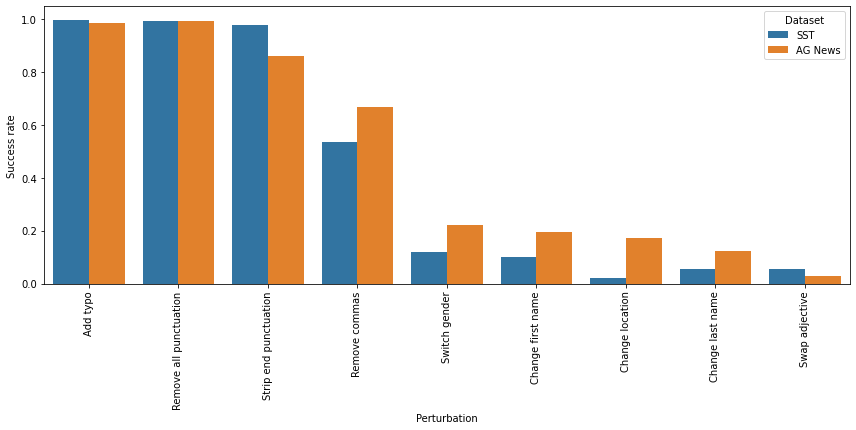

In [184]:
plt.figure(figsize=(12, 8))
sns.barplot(data=bert_shap_success_counts, x='Perturbation', y='success_rate', hue='Dataset')
plt.ylabel('Success rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig('reports/figures/bert_shap/perturbation_success_rate.png')
plt.show()

## Comparison between correct and incorrect predictions

SST

In [189]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_SST_BERT.pickle', 'rb'))

In [190]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

In [192]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue

    del df['spearman']
        
    df['top_k_idx_orig'] = df.apply(lambda x: set(np.argsort(-np.array(x[f'shap_orig_values']))[:k]), axis=1)
    df['top_k_idx_perturb'] = df.apply(lambda x: set(np.argsort(-x[f'shap_{perturbation}_values'])[:k]), axis=1)

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean_correct': df[df['correct_prediction'] == 1]['k_intersection'].mean(),
        'top_k_std_correct': df[df['correct_prediction'] == 1]['k_intersection'].std(),
        'spearman_mean_correct': df[df['correct_prediction'] == 1]['spearman'].mean(),
        'spearman_std_correct': df[df['correct_prediction'] == 1]['spearman'].std(),
        'count_correct': df[df['correct_prediction'] == 1]['k_intersection'].count(),
        'top_k_mean_incorrect': df[df['correct_prediction'] == 0]['k_intersection'].mean(),
        'top_k_std_incorrect': df[df['correct_prediction'] == 0]['k_intersection'].std(),
        'spearman_mean_incorrect': df[df['correct_prediction'] == 0]['spearman'].mean(),
        'spearman_std_incorrect': df[df['correct_prediction'] == 0]['spearman'].std(),
        'count_incorrect': df[df['correct_prediction'] == 0]['k_intersection'].count()
    }

In [194]:
results_df = pd.DataFrame(results_dict).T
results_df

,top_k_mean_correct,top_k_std_correct,spearman_mean_correct,spearman_std_correct,count_correct,top_k_mean_incorrect,top_k_std_incorrect,spearman_mean_incorrect,spearman_std_incorrect,count_incorrect
strip_punct,0.820952,0.261646,0.813848,0.249334,210.0,0.835294,0.284806,0.854246,0.186425,153.0
remove_commas,0.574757,0.351668,0.583545,0.342987,103.0,0.518987,0.358800,0.580596,0.328642,79.0
remove_all_punct,0.657343,0.329423,0.601199,0.383074,143.0,0.723711,0.307467,0.631667,0.328561,97.0
change_first_name,0.810526,0.329806,0.937981,0.079591,19.0,0.809091,0.311539,0.871043,0.209597,22.0
change_last_name,0.725000,0.452769,0.798708,0.220806,8.0,0.933333,0.123443,0.955257,0.049217,15.0
change_location,0.866667,0.115470,0.809521,0.160620,3.0,0.900000,0.141421,0.952134,0.024196,2.0
add_typo,0.861538,0.189466,0.775447,0.278119,13.0,0.975000,0.070711,0.925844,0.134997,8.0
switch_gender,0.936364,0.178740,0.958735,0.065939,22.0,0.905263,0.261351,0.961549,0.044401,19.0
swap_adj,0.860000,0.313404,0.890660,0.171808,10.0,0.600000,0.432049,0.835206,0.108558,4.0


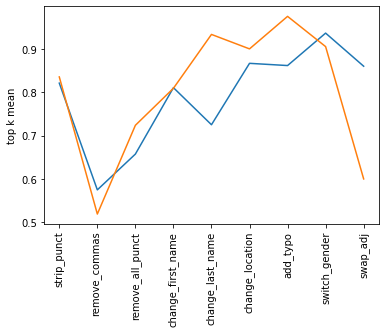

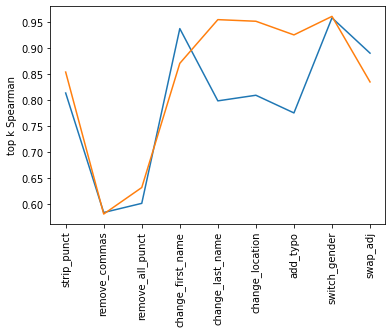

In [200]:
plt.plot(results_df.index, results_df['top_k_mean_correct'])
plt.plot(results_df.index, results_df['top_k_mean_incorrect'])
plt.ylabel('top k mean')
plt.xticks(rotation=90)
plt.show()

plt.plot(results_df.index, results_df['spearman_mean_correct'])
plt.plot(results_df.index, results_df['spearman_mean_incorrect'])
plt.ylabel('top k Spearman')
plt.xticks(rotation=90)
plt.show()

AG News

In [201]:
perturbation_df_dict = pickle.load(open('data/processed/perturbation_df_dict_AGNews_BERT.pickle', 'rb'))

In [202]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender', 'swap_adj'])

In [204]:
results_dict = {}

k=5
  
for perturbation, df in perturbation_df_dict.items():
    if df is None:
        continue
    
    df['top_k_idx_orig'] = df.apply(lambda x: set(np.argsort(-np.array(x[f'shap_orig_values']))[:k]), axis=1)
    df['top_k_idx_perturb'] = df.apply(lambda x: set(np.argsort(-x[f'shap_{perturbation}_values'])[:k]), axis=1)

    df['k_intersection'] = df.apply(lambda x: len(x['top_k_idx_orig'].intersection(x['top_k_idx_perturb'])) / k, axis=1)
    
    df['spearman'] = df.apply(lambda x: spearmanr(x['shap_orig_values'], x[f'shap_{perturbation}_values'])[0], axis=1)
    
    results_dict[perturbation] = {
        'top_k_mean_correct': df[df['correct_prediction'] == 1]['k_intersection'].mean(),
        'top_k_std_correct': df[df['correct_prediction'] == 1]['k_intersection'].std(),
        'spearman_mean_correct': df[df['correct_prediction'] == 1]['spearman'].mean(),
        'spearman_std_correct': df[df['correct_prediction'] == 1]['spearman'].std(),
        'count_correct': df[df['correct_prediction'] == 1]['k_intersection'].count(),
        'top_k_mean_incorrect': df[df['correct_prediction'] == 0]['k_intersection'].mean(),
        'top_k_std_incorrect': df[df['correct_prediction'] == 0]['k_intersection'].std(),
        'spearman_mean_incorrect': df[df['correct_prediction'] == 0]['spearman'].mean(),
        'spearman_std_incorrect': df[df['correct_prediction'] == 0]['spearman'].std(),
        'count_incorrect': df[df['correct_prediction'] == 0]['k_intersection'].count()
    }

In [205]:
results_df = pd.DataFrame(results_dict).T
results_df

,top_k_mean_correct,top_k_std_correct,spearman_mean_correct,spearman_std_correct,count_correct,top_k_mean_incorrect,top_k_std_incorrect,spearman_mean_incorrect,spearman_std_incorrect,count_incorrect
strip_punct,0.763746,0.322326,0.870712,0.228637,331.0,0.855172,0.232358,0.891167,0.129945,29.0
remove_commas,0.464730,0.391313,0.570895,0.377359,241.0,0.533333,0.438613,0.595209,0.340348,15.0
remove_all_punct,0.421818,0.351742,0.514338,0.358695,220.0,0.520000,0.368782,0.583563,0.286820,15.0
change_first_name,0.858974,0.264052,0.918236,0.151472,78.0,0.666667,0.577350,0.964177,0.061314,3.0
change_last_name,0.879167,0.260080,0.937991,0.128701,48.0,1.000000,0.000000,0.998817,0.001673,2.0
change_location,0.930769,0.162744,0.924762,0.150114,52.0,0.560000,0.384708,0.811786,0.174778,5.0
add_typo,0.820000,0.310517,0.867912,0.177702,20.0,1.000000,0.000000,0.939234,0.020341,2.0
switch_gender,0.908889,0.187619,0.933763,0.131710,90.0,1.000000,0.000000,0.994289,0.006877,2.0
swap_adj,0.760000,0.374759,0.906269,0.129224,10.0,0.600000,0.565685,0.933472,0.094086,2.0


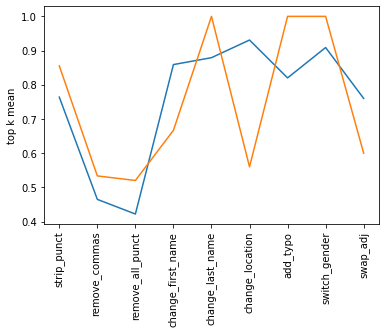

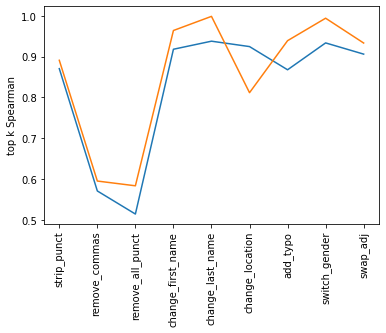

In [206]:
plt.plot(results_df.index, results_df['top_k_mean_correct'])
plt.plot(results_df.index, results_df['top_k_mean_incorrect'])
plt.ylabel('top k mean')
plt.xticks(rotation=90)
plt.show()

plt.plot(results_df.index, results_df['spearman_mean_correct'])
plt.plot(results_df.index, results_df['spearman_mean_incorrect'])
plt.ylabel('top k Spearman')
plt.xticks(rotation=90)
plt.show()

## Consistency of explainers

## TBC

In [207]:
kirill_sst_dev_500 = pd.read_parquet('data/external/sst_dev_500.parquet')
print(kirill_sst_dev_500.shape)
kirill_sst_dev_500.head()

(500, 54)


,sentence,label,tokens_orig,remove_commas_concat,remove_commas_tokens,remove_commas_success,remove_commas_pert_ind,remove_all_punct_concat,remove_all_punct_tokens,remove_all_punct_success,...,strip_punct_prediction,remove_commas_prediction,remove_all_punct_prediction,contraction_prediction,change_first_name_prediction,change_last_name_prediction,change_location_prediction,add_typo_prediction,switch_gender_prediction,swap_adj_prediction
3,"A warm , funny , engaging film .",4,"[a, warm, ,, funny, ,, engaging, film, .]",a warm funny engaging film .,"[a, warm, , funny, , engaging, film, .]",1,"[2, 4]",a warm funny engaging film,"[a, warm, , funny, , engaging, film, ]",1,...,4,3,3,4,4,4,4,3,4,4
6,"Entertains by providing good , lively company .",3,"[entertain, ##s, by, providing, good, ,, livel...",entertains by providing good lively company .,"[entertain, ##s, by, providing, good, , lively...",1,[5],entertains by providing good lively company,"[entertain, ##s, by, providing, good, , lively...",1,...,3,3,3,3,3,3,3,3,3,3
12,The band 's courage in the face of official re...,3,"[the, band, ', s, courage, in, the, face, of, ...",the band ' s courage in the face of official r...,"[the, band, ', s, courage, in, the, face, of, ...",1,[13],the band s courage in the face of official re...,"[the, band, , s, courage, in, the, face, of, o...",1,...,3,3,3,3,3,3,3,3,3,3
13,Although German cooking does not come readily ...,3,"[although, german, cooking, does, not, come, r...",although german cooking does not come readily ...,"[although, german, cooking, does, not, come, r...",1,[17],although german cooking does not come readily ...,"[although, german, cooking, does, not, come, r...",1,...,3,3,3,3,3,3,3,3,3,3
14,A beguiling splash of pastel colors and pranki...,4,"[a, beg, ##uil, ##ing, splash, of, paste, ##l,...",a beguiling splash of pastel colors and pranki...,"[a, beg, ##uil, ##ing, splash, of, paste, ##l,...",0,None,a beguiling splash of pastel colors and pranki...,"[a, beg, ##uil, ##ing, splash, of, paste, ##l,...",1,...,4,3,4,3,3,3,3,3,3,3


In [208]:
kirill_sst_dev_500.columns

Index(['sentence', 'label', 'tokens_orig', 'remove_commas_concat',
       'remove_commas_tokens', 'remove_commas_success',
       'remove_commas_pert_ind', 'remove_all_punct_concat',
       'remove_all_punct_tokens', 'remove_all_punct_success',
       'remove_all_punct_pert_ind', 'switch_gender_concat',
       'switch_gender_tokens', 'switch_gender_success',
       'switch_gender_pert_ind', 'strip_punct_concat', 'strip_punct_tokens',
       'strip_punct_success', 'strip_punct_pert_ind', 'add_typo_concat',
       'add_typo_tokens', 'add_typo_success', 'add_typo_pert_ind',
       'change_first_name_concat', 'change_first_name_tokens',
       'change_first_name_success', 'change_first_name_pert_ind',
       'change_last_name_concat', 'change_last_name_tokens',
       'change_last_name_success', 'change_last_name_pert_ind',
       'change_location_concat', 'change_location_tokens',
       'change_location_success', 'change_location_pert_ind',
       'contraction_concat', 'contraction_token

## TODOs

In [189]:
perturbation_df_dict.keys()

dict_keys(['strip_punct', 'remove_commas', 'remove_all_punct', 'contraction', 'change_first_name', 'change_last_name', 'change_location', 'add_typo', 'switch_gender'])

In [188]:
len(perturbation_df_dict.keys())

9

In [190]:
for k, v in perturbation_df_dict.items():
    if v is None:
        print(k)

contraction
change_first_name
change_location


- Intersection between explainers analysis (requires Kirill's results)
- Comparison between correct prediction and incorrect predictions __[DONE]__
- Use same examples as Kirill (see Discord for indices) __[DONE]__
- Double check implementation of perturbations which led to lowest means e.g. `remove_commas` __[DONE]__
- Add `swap_adj` implementation __[DONE]__
- Drop `contraction` __[DONE]__
- Use uppercase BERT tokenizer for perturbation df for the following perturbations: __[DONE]__
    - change_last_name
    - change_first_name
    - change_location
- Correct top-k calculation in main notebook or drop and compute post-hoc __[DONE]__